## Prepare the environment

In [1]:
from pprint import pprint
from scipy import io as sio
import numpy as np
import time
import cPickle
from pprint import pprint
import matplotlib.pyplot as plt
BASE_DIR = '/Users/baroc/repos/VideoActionRecognition/'

import sys
sys.path.append(BASE_DIR+'src/')
from node_generator import Node

## Load the nodes and edges

In [2]:
NODE_EDGE_DIR = BASE_DIR + "validation_node_edge/"
cPFile = open(NODE_EDGE_DIR+"validation_video_nodes.p", 'rb')
t = time.time()
node_list = cPickle.load(cPFile)
print time.time() - t 

4.30467009544


In [3]:
tFile = open(NODE_EDGE_DIR+"adj_list_by_temporal.p", 'rb')
t = time.time()
t_adj_list = cPickle.load(tFile)
print time.time() - t 

0.203194141388


In [4]:
fFile = open(NODE_EDGE_DIR+"adj_list_by_feature_k_7_sigma_2000.p", 'rb')
t = time.time()
f_adj_list = cPickle.load(fFile)
print time.time() - t 

0.25422501564


* Finished loading the nodes in 4.27256393433 seconds, 
* temporal adjacent list 0.169546127319 seconds, 
* feature adjacent list 0.295833110809 secondes

## Next step: sort the nodes by label
### First set ids(in case the nodes are not healthy)

In [5]:
for i,node in enumerate(node_list):
        node.set_id(i)

In [6]:
labels_id = []
for node in node_list:
    if len(node.labels) == 1:
        labels_id.append([node.labels[0],node.id])
    elif len(node.labels) > 1:
        for label in node.labels:
            labels_id.append([label,node.id])
    else:
        labels_id.append(['_Background',node.id])
labels_id = sorted(labels_id)
pprint(len(labels_id))

12269


    # labels_id = [[node.labels,node.id] for node in node_list if len(node.labels)>0]

    # pprint(labels_id)

    # print [node.id for node in node_list]

    pprint((labels_id))
    pprint(len(node_list))

    f_adj_list[12202]

Now we have a list of nodes with labels and ids. Sorted on labels. We can easily get an node's id by its index, but we cannot get its index by its id. So next step we build a mapping from node_id to its index in the matrix.
## Build the id - idx mapping
The mapping is a node id -> [list of idx], because the fact that some nodes have multiple labels. 

In [7]:
idx_dict = dict()
i = 0
for node in labels_id:
    if node[1] not in idx_dict:
        idx_dict[node[1]] = []
    idx_dict[node[1]].append(i)
    i +=1

In [8]:
f_adj_list[:2]

[[(0.9851860720657167, 1),
  (0.9679800997755401, 2),
  (0.8983688939397387, 544),
  (0.9761473310663726, 2800),
  (0.9755042618897662, 2802),
  (0.9754352474046538, 2811),
  (0.9765666763930281, 6003),
  (0.8375802072649162, 8456),
  (0.9769275844536133, 9701),
  (0.9752245761445295, 10675)],
 [(0.9851860720657167, 0),
  (0.9760924243232667, 2),
  (0.9778419278262991, 772),
  (0.9780494968029587, 6007),
  (0.9780644121715143, 9348),
  (0.9777319267970926, 9391),
  (0.9777253271288606, 9747),
  (0.9782544196374563, 10675)]]

## Build the matrices
* `f_mat`
* `t_mat`
* `f_mat_22`
* `f_mat_22_normalized`

Important info to remember
* `labels_id` is a list of `[label, nodeID]` pairs sorted by label
* `adj_list` is a list of lists, list at index i means the adjacent list of node i. each element in the list is a tuple of pair `(weight, node_id)`

In [9]:
f_mat = np.zeros([len(labels_id),len(labels_id)])
i = 0
for node in labels_id:
    adlist = f_adj_list[node[1]]
    for edge in adlist:
        idx = idx_dict[edge[1]]
        f_mat[i][idx] = 1
    i += 1

In [10]:
t_mat = np.zeros([len(labels_id),len(labels_id)])
i = 0
for node in labels_id:
    adlist = t_adj_list[node[1]]
    for edge in adlist:
        idx = idx_dict[edge[1]]
        t_mat[i][idx] = 1
    i += 1

In [11]:
# plt.matshow(f_mat)
# Display a random matrix with a specified figure number and a grayscale
# colormap
# plt.matshow(np.random.rand(64, 64), fignum=100, cmap=plt.cm.gray)
# plt.savefig('matrix.bmp')
# plt.show()

In [13]:
fig = plt.figure()
plt.matshow(f_mat,cmap='Greys')
plt.savefig('f_matrix3000.png', dpi=3000)

## This part is checking the correctness of the code
result is the code is correct

In [17]:
fig = plt.figure()
plt.matshow(t_mat[10000:11000,10000:11000], cmap='Greys')
# plt.show()
plt.savefig('t_matrix1000_detail.png',figsize =(10,10), dpi=2000)

In [51]:
print(t_mat[10020:10025,10020:10025])

[[ 0.  1.  0.  0.  0.]
 [ 1.  0.  1.  0.  0.]
 [ 0.  1.  0.  1.  1.]
 [ 0.  0.  1.  0.  1.]
 [ 0.  0.  1.  1.  0.]]


In [57]:
pprint(labels_id[10020:10025])
pprint(idx_dict[9663])
pprint(labels_id[46])
node_list[9663].labels

[['_Background', 9661],
 ['_Background', 9662],
 ['_Background', 9664],
 ['_Background', 9665],
 ['_Background', 9666]]
[46]
['BaseballPitch', 9663]


['BaseballPitch']

In [14]:
plt.savefig('t_matrix2500.png', dpi=2500)

In [16]:
plt.savefig('matrix.png', dpi=1000)

In [17]:
# plt.savefig('matrix.bmp', dpi=1000)
# Not good

In [20]:
plt.savefig('matrix2000.png', dpi=2000)

In [15]:
plt.savefig('t_matrix3000.png', dpi=3000)

In [ ]:
plt.savefig('matrix4000.png', dpi=4000)

In [ ]:
# sio.savemat('matrix.mat', {'f_matrix':f_mat,'t_matrix':t_mat})

In [12]:
cPickle.dump( {'f_matrix':f_mat,'t_matrix':t_mat}, open( NODE_EDGE_DIR +"mats.p", "wb" ) )

In [12]:
fig = plt.figure()
plt.matshow(f_mat[:1662,:1662],cmap='Greys')
plt.savefig('f_matrix_positive3000.png', dpi=3000)

In [41]:
fig = plt.figure()
plt.matshow(t_mat[:1662,:1662],cmap='Greys')
plt.savefig('t_matrix_positive3000.png', dpi=3000)

In [29]:
# idx_dict_positive = dict()
# i = 0
# for node in labeled_nodes:
#     if node[1] not in idx_dict_positive:
#         idx_dict_positive[node[1]] = []
#     idx_dict_positive[node[1]].append(i)
#     i +=1

In [31]:
# f_mat_labeled = np.zeros([len(labeled_nodes),len(labeled_nodes)])
# i = 0
# for node in labeled_nodes:
#     adlist = f_adj_list[node[1]]
#     for edge in adlist:
#         if edge[1] in idx_dict_positive:
#             idx = idx_dict_positive[edge[1]]
#         if idx < len(labeled_nodes):
#             f_mat_labeled[i][idx] = 1
#     i += 1

In [32]:
# t_mat_labeled = np.zeros([len(labeled_nodes),len(labeled_nodes)])
# i = 0
# for node in labeled_nodes:
#     adlist = t_adj_list[node[1]]
#     for edge in adlist:
#         if edge[1] in idx_dict_positive:
#             idx = idx_dict_positive[edge[1]]
#         if idx < len(labeled_nodes):
#             t_mat_labeled[i][idx] = 1
#     i += 1

In [33]:
# fig = plt.figure()
# plt.matshow(f_mat_labeled,cmap='Greys')
# plt.savefig('f_matrix_positive3000.png', dpi=3000)

In [34]:
# fig = plt.figure()
# plt.matshow(t_mat_labeled,cmap='Greys')
# plt.savefig('t_matrix_positive3000.png', dpi=3000)

## prepare to draw the 22-22 Plot

In [11]:
def count_label(labels_dict,label):
    if label in labels_dict:
        labels_dict[label] +=1
    else:
        labels_dict[label] =1

In [13]:
labeled_nodes = []
# labels = set()
labels_dict = dict()
for node in node_list:
    if len(node.labels) == 1:
        labeled_nodes.append([node.labels[0],node.id])
        count_label(labels_dict,node.labels[0])
#         labels.add(node.labels[0])
    elif len(node.labels) > 1:
        for label in node.labels:
            labeled_nodes.append([label,node.id])
            count_label(labels_dict,label)
#             labels.add(label)
    else:
        count_label(labels_dict,"_Background")
#         labels.add("_Background")
        
# labels = sorted(labels)
len(labeled_nodes)

1662

In [14]:
labels = sorted(list(labels_dict))
print(labels)

['Ambiguous', 'BaseballPitch', 'BasketballDunk', 'Billiards', 'CleanAndJerk', 'CliffDiving', 'CricketBowling', 'CricketShot', 'Diving', 'FrisbeeCatch', 'GolfSwing', 'HammerThrow', 'HighJump', 'JavelinThrow', 'LongJump', 'PoleVault', 'Shotput', 'SoccerPenalty', 'TennisSwing', 'ThrowDiscus', 'VolleyballSpiking', '_Background']


In [15]:
print(labels_dict)
labels_dict[labels[1]]

{'PoleVault': 112, 'CleanAndJerk': 26, 'Billiards': 53, 'CricketShot': 13, 'HammerThrow': 225, 'BaseballPitch': 27, 'CliffDiving': 66, 'CricketBowling': 16, 'ThrowDiscus': 57, '_Background': 10607, 'Shotput': 58, 'SoccerPenalty': 43, 'Ambiguous': 42, 'JavelinThrow': 205, 'LongJump': 147, 'HighJump': 208, 'VolleyballSpiking': 18, 'BasketballDunk': 70, 'TennisSwing': 17, 'FrisbeeCatch': 33, 'Diving': 210, 'GolfSwing': 16}


27

In [16]:
labels
labels.index("Ambiguous")

0

In [17]:
f_mat_22 = np.zeros([len(labels),len(labels)])
i = 0
for node in labels_id:
    adlist = f_adj_list[node[1]]
    idx = labels.index(node[0])
    for edge in adlist:
        idx_list = idx_dict[edge[1]]
        if len(idx_list) == 1:
            jdx = labels.index(labels_id[idx_list[0]][0])
            f_mat_22[jdx][idx] += 1
        else:
            for index in idx_list:
                jdx = labels.index(labels_id[index][0])
                f_mat_22[jdx][idx] += 1
    i += 1

## un-normalized results

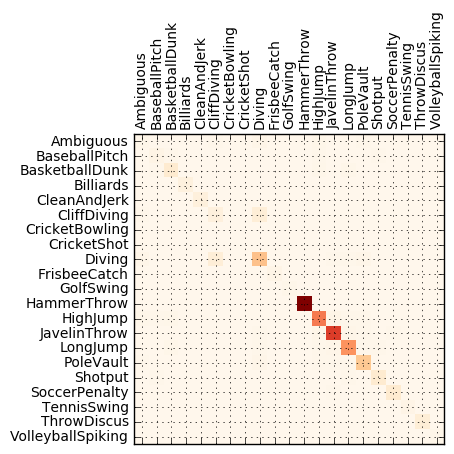

In [44]:
fig = plt.figure()
plt.matshow(f_mat_22[:21,:21],cmap = 'OrRd')
plt.xticks(range(len(labels[:-1])), labels, rotation='vertical')
plt.yticks(range(len(labels[:-1])), labels)
plt.grid()
plt.show()
# plt.savefig('f_matrix_positive3000.png', dpi=3000)

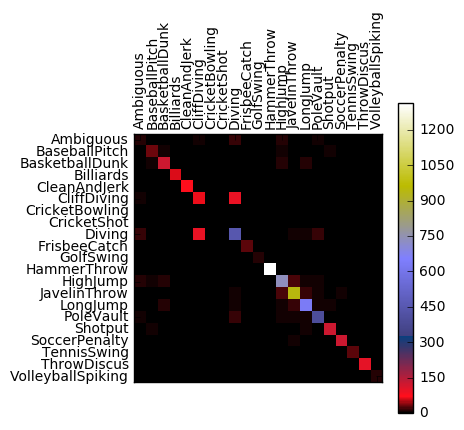

In [50]:
fig = plt.figure()
plt.matshow(f_mat_22[:21,:21],cmap='gist_stern')
plt.xticks(range(len(labels[:-1])), labels, rotation='vertical')
plt.yticks(range(len(labels[:-1])), labels)
plt.colorbar()
plt.show()

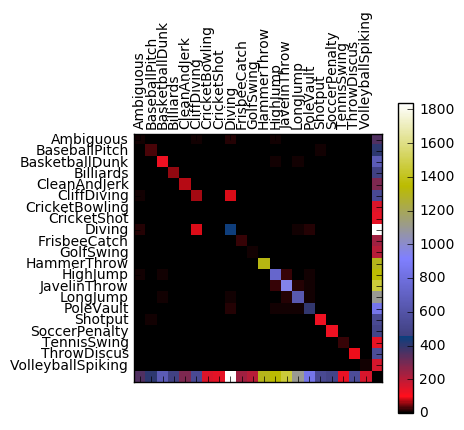

In [51]:
f_mat_22_mute = np.copy(f_mat_22)
f_mat_22_mute[-1][-1] = 0
fig = plt.figure()
plt.matshow(f_mat_22_mute,cmap='gist_stern')
plt.xticks(range(len(labels[:-1])), labels, rotation='vertical')
plt.yticks(range(len(labels[:-1])), labels)
plt.colorbar()
plt.show()

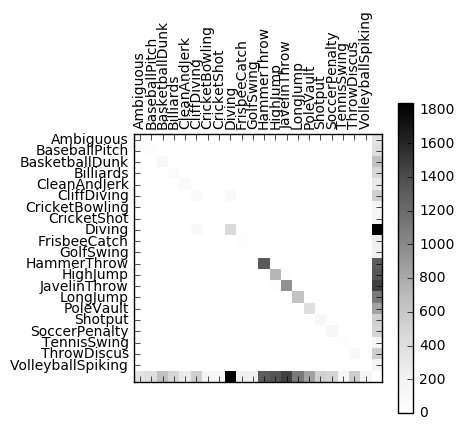

In [52]:
fig = plt.figure()
plt.matshow(f_mat_22_mute,cmap='Greys')
plt.xticks(range(len(labels[:-1])), labels, rotation='vertical')
plt.yticks(range(len(labels[:-1])), labels)
plt.colorbar()
plt.show()

In [73]:

normalized_f_mat_22 = np.copy(f_mat_22)
for i in range(len(labels)):
    for j in range(len(labels)):
        normalized_f_mat_22[i][j] = normalized_f_mat_22[i][j]/labels_dict[labels[i]]/labels_dict[labels[j]]

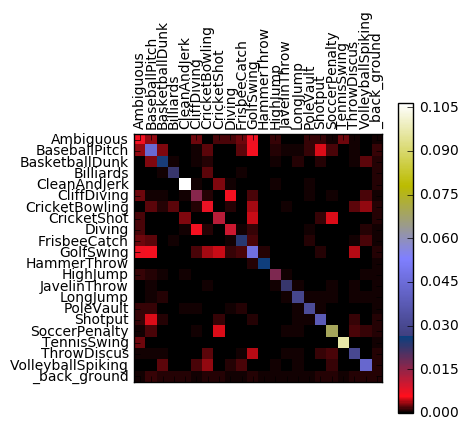

In [76]:
fig = plt.figure()
plt.matshow(normalized_f_mat_22,cmap='gist_stern')
plt.xticks(range(len(labels)), labels, rotation='vertical')
plt.yticks(range(len(labels)), labels)
plt.colorbar()
plt.show()

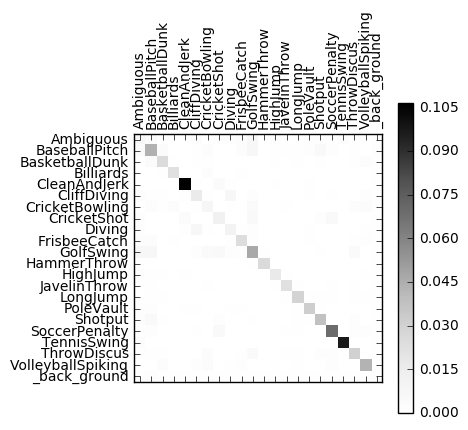

In [77]:
fig = plt.figure()
plt.matshow(normalized_f_mat_22,cmap='Greys')
plt.xticks(range(len(labels)), labels, rotation='vertical')
plt.yticks(range(len(labels)), labels)
plt.colorbar()
plt.show()

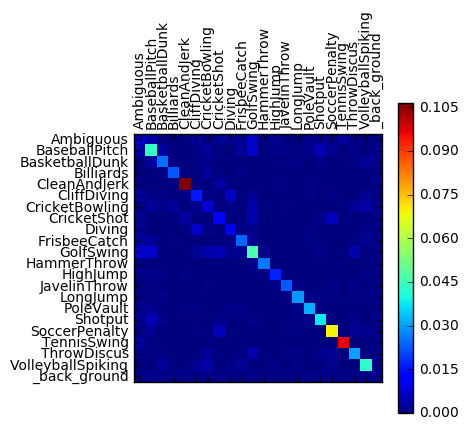

In [80]:
fig = plt.figure()
plt.matshow(normalized_f_mat_22,cmap='jet')
plt.xticks(range(len(labels)), labels, rotation='vertical')
plt.yticks(range(len(labels)), labels)
plt.colorbar()
plt.show()

Compute `t_mat_22` and `t_mat_normalized`

In [18]:
t_mat_22 = np.zeros([len(labels),len(labels)])
i = 0
for node in labels_id:
    adlist = t_adj_list[node[1]]
    idx = labels.index(node[0])
    for edge in adlist:
        idx_list = idx_dict[edge[1]]
        if len(idx_list) == 1:
            jdx = labels.index(labels_id[idx_list[0]][0])
            t_mat_22[jdx][idx] += 1
        else:
            for index in idx_list:
                jdx = labels.index(labels_id[index][0])
                t_mat_22[jdx][idx] += 1
    i += 1
normalized_t_mat_22 = np.copy(t_mat_22)
for i in range(len(labels)):
    for j in range(len(labels)):
        normalized_t_mat_22[i][j] = normalized_t_mat_22[i][j]/labels_dict[labels[i]]/labels_dict[labels[j]]

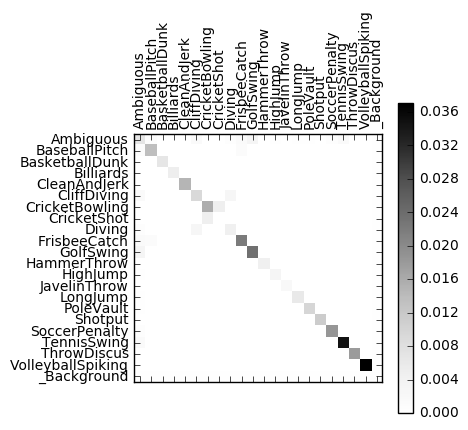

In [19]:
fig = plt.figure()
plt.matshow(normalized_t_mat_22,cmap='Greys')
plt.xticks(range(len(labels)), labels, rotation='vertical')
plt.yticks(range(len(labels)), labels)
plt.colorbar()
plt.show()

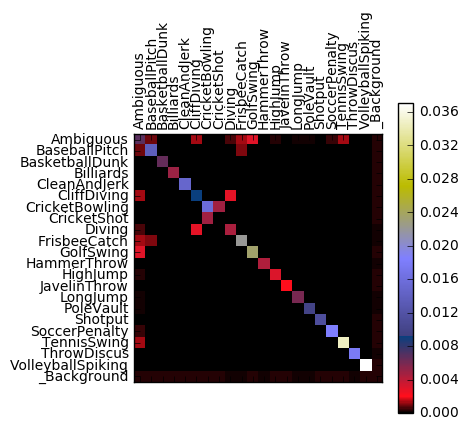

In [20]:
fig = plt.figure()
plt.matshow(normalized_t_mat_22,cmap='gist_stern')
plt.xticks(range(len(labels)), labels, rotation='vertical')
plt.yticks(range(len(labels)), labels)
plt.colorbar()
plt.show()